# 1 - First steps and statement

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from skimage import io

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assessments. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## 1.1 - Loading data

In [2]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
102817,00027415_050.png,No Finding,50,27415,23,M,AP,2508,2796,0.139,0.139,NaN
56245,00014018_002.png,No Finding,2,14018,46,M,AP,2500,2048,0.168,0.168,NaN
34193,00008962_003.png,No Finding,3,8962,59,F,PA,2992,2991,0.143,0.143,NaN
63548,00015679_004.png,Atelectasis,4,15679,64,M,AP,3056,2528,0.139,0.139,NaN
61744,00015255_017.png,Infiltration,17,15255,47,M,AP,2500,2048,0.168,0.168,NaN


In [3]:
# Let's have a look to the column names
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [4]:
# We have a column with the name 'Unnamed: 11'. What values does it have?
all_xray_df['Unnamed: 11']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
112115   NaN
112116   NaN
112117   NaN
112118   NaN
112119   NaN
Name: Unnamed: 11, Length: 112120, dtype: float64

In [5]:
# Nothing interesting in that column, so we drop it
all_xray_df = all_xray_df.drop('Unnamed: 11', axis=1)
print(all_xray_df.columns)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')


In [6]:
# Now we explore the columns we have. As we can see, there's no
# NA values.
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


In [7]:
# We also explore some statistics about our dataset
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


Now we can see that there is a problem in the data of age, since the maximum age can't be 414. Before fixing this problem we are going to adapt the entire dataset to facilitate the EDA.

## 1.2 - Re-arranging the dataset to facilitate EDA

First we explore the differents tags that we can have in the _Finding Label_ column

In [8]:
# Look for unique values in 'Finding Labels'
print(np.unique(all_xray_df['Finding Labels']))

['Atelectasis' 'Atelectasis|Cardiomegaly'
 'Atelectasis|Cardiomegaly|Consolidation'
 'Atelectasis|Cardiomegaly|Consolidation|Edema'
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration'
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration|Mass'
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration|Mass|Nodule'
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Mass'
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Pleural_Thickening'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Mass'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Mass|Pleural_Thickening'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Nodule|Pleural_Thickening'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Pneumonia'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Mass'
 'Atelectas

As it can be seen in the cell before, there's a lot of different values. Furthermore, each value can be a single disease or even a list of diseases separated by the | character.

In order to do the EDA easier, I'm going to separate the different tags in columns.

In [9]:
# Get all possible labels and leave them in a list
all_labels = list(np.unique(list(chain(*all_xray_df['Finding Labels'].map(
    lambda x: x.split('|')).tolist()))))
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [10]:
# Now I create a new column in the dataframe for each disease. In each of these
# new columns I will assign a 1 if the disease is present in the "Finding Labels"
# field, and a 0 otherwise.
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(
        lambda finding: 1.0 if c_label in finding else 0)

In [11]:
# And let's explore 5 samples by random.
all_xray_df.sample(5, random_state=10)[['Finding Labels'] + all_labels]

,Finding Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
24281,Consolidation,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,Cardiomegaly|Effusion|Infiltration,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14105,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
31127,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46995,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# 2 - Patient demographic data

## 2.1 - Age

### 2.1.1 - Age in entire dataset

A few cells ago we saw that the variable _Age_ takes on some surprising values. They are outliers. Now we are going to identify and filter them.

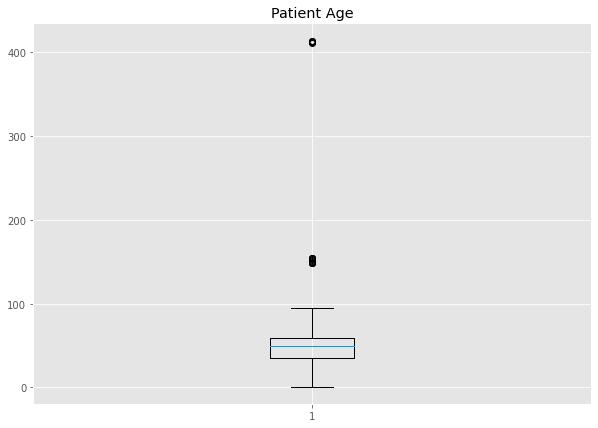

In [12]:
# Notice that the maximum of age is 414. It isn't reasonable.
# Let's have a look to a boxplot to check distribution and outliers
plt.style.use("ggplot")
fig = plt.figure(figsize =(10, 7))
_ = plt.boxplot(all_xray_df['Patient Age'])
_ = plt.title("Patient Age")

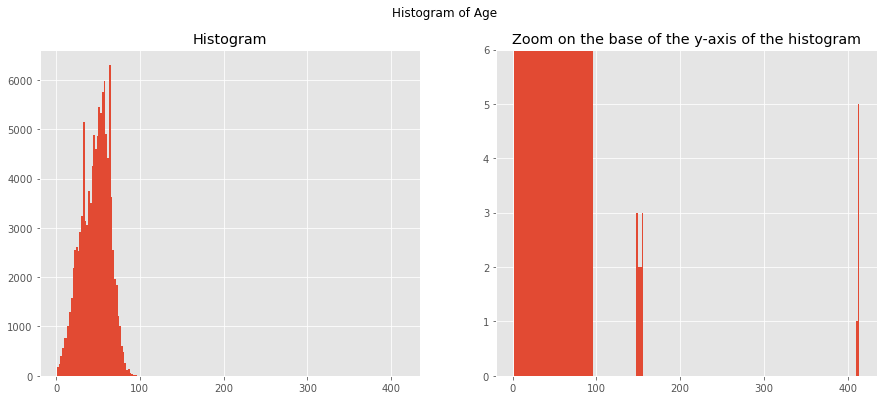

In [13]:
# Let's have a closer look through the histogram,
# including a zoom in to the base of y-axis
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Histogram of Age')
_ = ax1.hist(all_xray_df['Patient Age'], bins=200)
_ = ax1.set_title("Histogram")
_ = ax2.hist(all_xray_df['Patient Age'], bins=200)
_ = plt.ylim((0, 6))
_ = ax2.set_title("Zoom on the base of the y-axis of the histogram")

Those values greater than 100 are outliers, so we are going to drop them all.

In [14]:
# Droping outliers in age
all_xray_df = all_xray_df.loc[all_xray_df['Patient Age']<100]

In [15]:
# And check that we don't have that problem anymore
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,...,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,0.103101,0.024763,0.041631,...,0.022443,0.015040,0.002025,0.177433,0.051550,0.538366,0.056474,0.030186,0.012756,0.047286
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,0.304092,0.155402,0.199745,...,0.148121,0.121711,0.044954,0.382037,0.221118,0.498528,0.230836,0.171100,0.112220,0.212252
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# # Check the histogram ans boxplot too, to see in there's any
# # remanining problem
# plt.style.use("ggplot")
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
# fig.suptitle('Variable: Age')
# _ = ax1.hist(all_xray_df['Patient Age'], bins=100)
# _ = ax1.set_title("Histogram")
# _ = ax2.boxplot(all_xray_df['Patient Age'])
# _ = ax2.set_title("Boxplot")

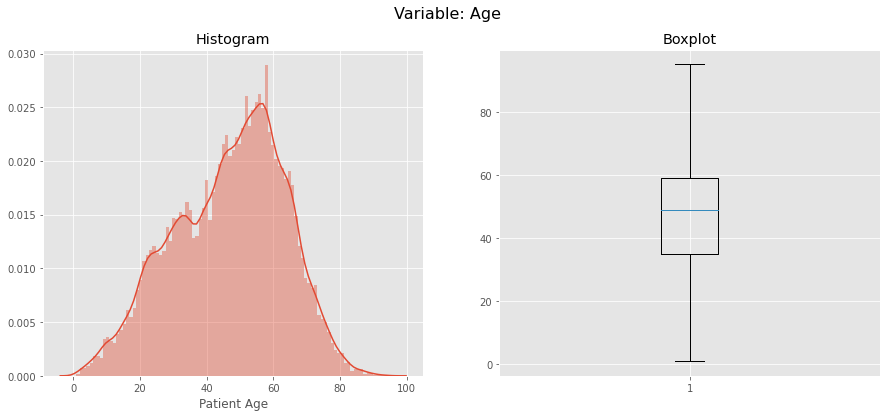

In [17]:
# Check the histogram ans boxplot too, to see in there's any
# remanining problem
plt.style.use("ggplot")
plt.figure(figsize=(15, 6))
plt.suptitle('Variable: Age', fontsize=16)

# Subplot 1 - Histogram
plt.subplot(121)
sns.distplot(all_xray_df['Patient Age'],
             bins=len(np.unique(all_xray_df['Patient Age'])));
_ = plt.title('Histogram')

# Subplot 2 - Boxplot
plt.subplot(122)
plt.boxplot(all_xray_df['Patient Age'])
_ = plt.title('Boxplot')

### 2.1.2 - Creation of a pneumonia dataframe

With the analysis of the first variable (age) we see the convenience of building a new dataframe with the data of the pneumonia cases. This data frame will be used to make the rest of the comparisons between the general dataset and the pneumonia dataset on each variable explored.

In [18]:
# Now we create a dataframe with the subset of pneumonia==1
df = all_xray_df[all_xray_df.Pneumonia==1]
df = df.drop(['Pneumonia', 'No Finding'], axis=1)
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumothorax
count,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000
mean,14.439161,14389.927273,44.670629,2668.407692,2442.060839,0.155042,0.155042,0.183217,0.028671,0.086014,0.237762,0.187413,0.016084,0.007692,0.002098,0.423077,0.049650,0.048951,0.033566,0.028671
std,20.078227,7976.454258,17.639098,329.090274,388.530801,0.015190,0.015190,0.386979,0.166939,0.280483,0.425862,0.390379,0.125842,0.087398,0.045771,0.494220,0.217298,0.215841,0.180173,0.166939
min,0.000000,13.000000,2.000000,1581.000000,1537.000000,0.115000,0.115000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,8230.000000,31.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,14254.500000,46.000000,2500.000000,2500.000000,0.143000,0.143000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,19920.000000,59.000000,2992.000000,2846.500000,0.168000,0.168000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,155.000000,30801.000000,90.000000,3056.000000,3056.000000,0.194314,0.194314,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# Built a list with the column names of the diseases that can exist
# in the pneumonia dataset, except pneumonia
all_labels_pn = all_labels.copy()
all_labels_pn.remove('No Finding')
all_labels_pn.remove('Pneumonia')
print(all_labels_pn)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']


### 2.1.3 - Age in pneumonia subset

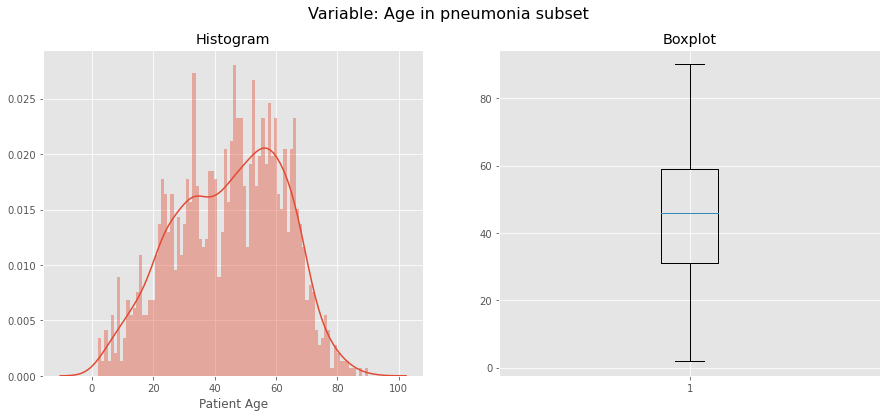

In [20]:
# And compare to the same data applied only to those
# patients with pneumonia
plt.style.use("ggplot")
plt.figure(figsize=(15, 6))
plt.suptitle('Variable: Age in pneumonia subset', fontsize=16)

# Subplot 1 - Histogram
plt.subplot(121)
sns.distplot(df['Patient Age'], bins=len(np.unique(df['Patient Age'])));
_ = plt.title('Histogram')

# Subplot 2 - Boxplot
plt.subplot(122)
plt.boxplot(df['Patient Age'])
_ = plt.title('Boxplot')

As we can see, we've fixed the problem with the outliers. On the other hand, we see that the age distribution is not the same in the main dataset than in the subset of pneumonia patients. The subset of pneumonia has a distribution more symmetric and a mean a little bit lower.

## 2.2- Number of cases of pneumonia and non-pneumonia in the dataset

In [21]:
# Number of cases in the entire dataset (meaning length of the dataset)
n_cases = len(all_xray_df)

# Number of cases of pneumonia
n_cases_pn = len(df)

print('The percentage of pneumonia cases over the entire dataset is {:.1f}%'.format(
    100 * n_cases_pn / n_cases))

The percentage of pneumonia cases over the entire dataset is 1.3%


As we can see, the percentage of pneumonia cases in the dataset is very low. It'll have to be taken into account when building the dataset for training.

## 2.3 - Gender

Now we look at the differences in gender in the patients of the dataset compared to the differences in the pneumonia subset.

In [22]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["darkorange", "gold"])

Entire dataset
Number of males: 63328
Number of females: 48776

Pneumonia subset
Number of males: 837
Number of females: 593


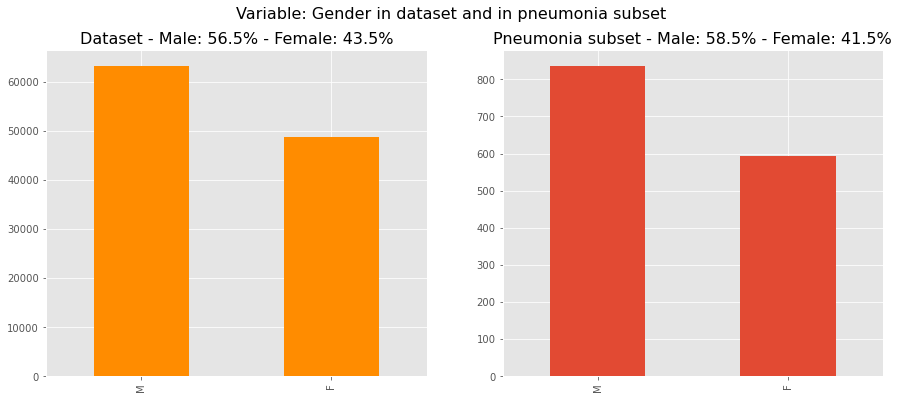

In [23]:
# Calculation of males in the entire dataset
n_males_1 = len(all_xray_df[all_xray_df['Patient Gender']=='M'])
print('Entire dataset')
print('Number of males: {}'.format(n_males_1))

# Calculation of females in the entire dateset
n_females_1 = len(all_xray_df[all_xray_df['Patient Gender']=='F'])
print('Number of females: {}'.format(n_females_1))

# Calculation of males in the pneumonia subset
n_males_2 = len(all_xray_df[(all_xray_df['Patient Gender']=='M') & (all_xray_df['Pneumonia']==1)])
print('\nPneumonia subset')
print('Number of males: {}'.format(n_males_2))

# Calculation of females in the entire dateset
n_females_2 = len(all_xray_df[(all_xray_df['Patient Gender']=='F') & (all_xray_df['Pneumonia']==1)])
print('Number of females: {}'.format(n_females_2))

# Plots
plt.style.use("ggplot")
plt.figure(figsize=(15, 6))
plt.suptitle('Variable: Gender in dataset and in pneumonia subset', fontsize=16)

# Subplot 1 - Barplot 1
plt.subplot(121)
all_xray_df['Patient Gender'].value_counts().plot(kind='bar', colormap=cmap);
_ = plt.title('Dataset - Male: {:.1f}% - Female: {:.1f}%'.format(
    100 * n_males_1 / (n_males_1 + n_females_1),
    100 * n_females_1 / (n_males_1 + n_females_1)),
             fontsize=16)

# Subplot 2 - Barplot 2
plt.subplot(122)
df['Patient Gender'].value_counts().plot(kind='bar');
_ = plt.title('Pneumonia subset - Male: {:.1f}% - Female: {:.1f}%'.format(
    100 * n_males_2 / (n_males_2 + n_females_2),
    100 * n_females_2 / (n_males_2 + n_females_2)),
             fontsize=16)

# Another way to plot the same
# sns.countplot(data=df, x='Patient Gender');

The differences in percentage doesn't seem too much relevant.

## 2.4 - View position

We explore now the variable _view position_. First of all let's check for unique values.

In [24]:
# Unique values
np.unique(all_xray_df['View Position'])

array(['AP', 'PA'], dtype=object)

In [25]:
# General statistics in the dataset
all_xray_df['View Position'].describe()

count     112104
unique         2
top           PA
freq       67299
Name: View Position, dtype: object

In [26]:
# General statistics in pneumonia subset
df['View Position'].describe()

count     1430
unique       2
top         AP
freq       800
Name: View Position, dtype: object

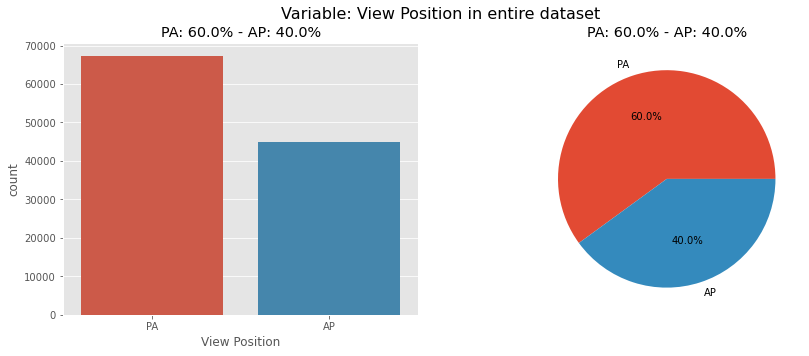

In [27]:
# Calculate proportions in the full dataset
p_pa = all_xray_df['View Position'].value_counts().PA / n_cases
p_ap = all_xray_df['View Position'].value_counts().AP / n_cases

# Plots entire dataset
plt.style.use("ggplot")
plt.figure(figsize=(14, 5))
plt.suptitle('Variable: View Position in entire dataset', fontsize=16)

# Subplot 1 - Barplot
plt.subplot(121)
sns.countplot(data=all_xray_df, x='View Position');
_ = plt.title('PA: {:.1f}% - AP: {:.1f}%'.format(
    100 * p_pa, 100 * p_ap, fontsize=16))

# Subplot 2 - Pie
plt.subplot(122)
data = list(all_xray_df['View Position'].value_counts())
labels = list(all_xray_df['View Position'].value_counts().index)
plt.pie(data, labels=labels, autopct='%.1f%%')
# all_xray_df['View Position'].value_counts().plot(kind='pie');
_ = plt.title('PA: {:.1f}% - AP: {:.1f}%'.format(
    100 * p_pa, 100 * p_ap, fontsize=16))

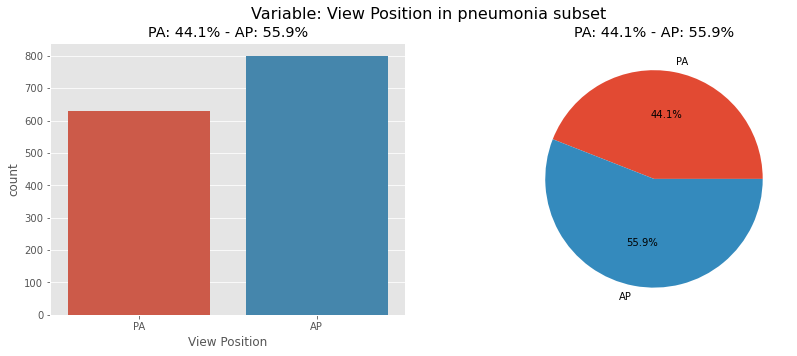

In [28]:
# Same analysis in pneumonia subset

# Calculate proportions
p_pa = df['View Position'].value_counts().PA / n_cases_pn
p_ap = df['View Position'].value_counts().AP / n_cases_pn

# Plots entire dataset
plt.style.use("ggplot")
plt.figure(figsize=(14, 5))
plt.suptitle('Variable: View Position in pneumonia subset', fontsize=16)

# Subplot 1 - Barplot
plt.subplot(121)
sns.countplot(data=df, x='View Position',
              order=df['View Position'].value_counts(ascending=True).index);
_ = plt.title('PA: {:.1f}% - AP: {:.1f}%'.format(
    100 * p_pa, 100 * p_ap, fontsize=16))

# Subplot 2 - Pie
plt.subplot(122)
data = list(df['View Position'].value_counts())
labels = list(df['View Position'].value_counts().index)
plt.pie(data[::-1], labels=labels[::-1], autopct='%.1f%%')
_ = plt.title('PA: {:.1f}% - AP: {:.1f}%'.format(
    100 * p_pa, 100 * p_ap, fontsize=16))

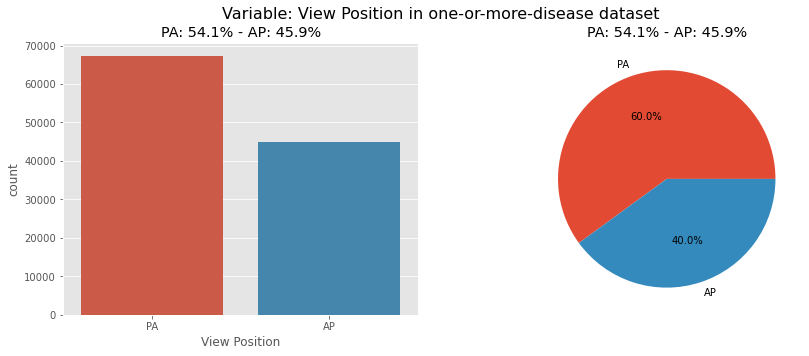

In [30]:
# Same analysis in the one-or-more-disease dataset

# Number of cases with "No Finding"=0
n_cases_NF = len(all_xray_df[all_xray_df['No Finding']==0])

# Calculate the proportion of PA and AP in the population in which at least one disease has been found
p_pa = all_xray_df[all_xray_df['No Finding']==0]['View Position'].value_counts().PA / n_cases_NF
p_ap = all_xray_df[all_xray_df['No Finding']==0]['View Position'].value_counts().AP / n_cases_NF

# Plots entire dataset
plt.style.use("ggplot")
plt.figure(figsize=(14, 5))
plt.suptitle('Variable: View Position in one-or-more-disease dataset', fontsize=16)

# Subplot 1 - Barplot
plt.subplot(121)
sns.countplot(data=all_xray_df, x='View Position');
_ = plt.title('PA: {:.1f}% - AP: {:.1f}%'.format(
    100 * p_pa, 100 * p_ap, fontsize=16))

# Subplot 2 - Pie
plt.subplot(122)
data = list(all_xray_df['View Position'].value_counts())
labels = list(all_xray_df['View Position'].value_counts().index)
plt.pie(data, labels=labels, autopct='%.1f%%')
# all_xray_df['View Position'].value_counts().plot(kind='pie');
_ = plt.title('PA: {:.1f}% - AP: {:.1f}%'.format(
    100 * p_pa, 100 * p_ap, fontsize=16))

The chest radiograph is usually acquired with the X-ray beam passing through the patient from Posterior to Anterior (PA); but sometimes, due to the poor condition of the patient, it must be acquired from Anterior to Posterior (AP).

In this case, as we can see in the plots above, the proportions in the entire dataset and pneumonia subset are quite differents. In the second case, the proportion of AP is higher than the one seen in the whole dataset, and that suggests that the patient state of pneumonia subset could be worse than the general dataset.

On the other hand, the population with at least one disease, has a proportion (54.1%) of PA view higher than the pneumonia dataset (44.1%) and lowe than the full dataset (60.0%)

# 3 - Distribution of diseases

## 3.1 - General distribution

First of all, I'll have a look to the distribution of values that the variable _Finding_ _Labels_ can have. As there are a lot of combinations of diseases, I'll just show the 30 first tags of _Finding Labels_.

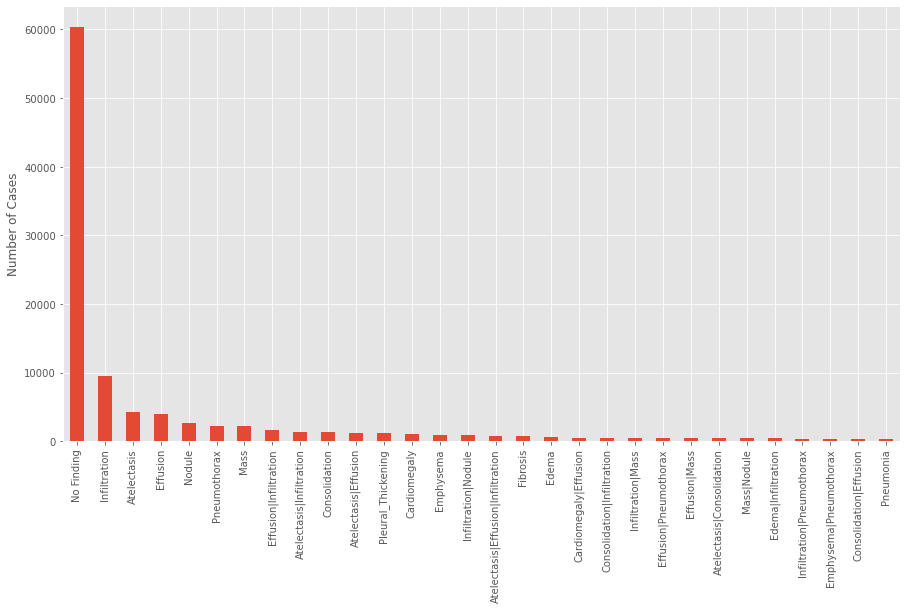

In [29]:
plt.figure(figsize=(15, 8))
all_xray_df['Finding Labels'].value_counts()[0:30].plot(kind='bar');
_ = plt.ylabel('Number of Cases')

In [30]:
# Since the "No finding" case excludes all other possibilities
# we can calculate the percentage of the dataset that has no
# disease
n_no_finding = len(all_xray_df[all_xray_df['Finding Labels']=='No Finding'])
print('The number of samples with no finding is {}. That means that \
there is a percentage of {:.1f}% over the entire dataset that has \
no disease'.format(n_no_finding, 100 * n_no_finding / n_cases))

The number of samples with no finding is 60353. That means that there is a percentage of 53.8% over the entire dataset that has no disease


Due to the high percentage of No Findings in the dataset, it will have to be taken into account when building the training dataset.

Another interesting point is to know the correlation between pneumonia and other diseases.

Pneumonia             1.000000
Edema                 0.174110
Infiltration          0.073088
Atelectasis           0.029948
Consolidation         0.025257
Effusion              0.024112
Cardiomegaly          0.002859
Pleural_Thickening    0.002246
Hernia                0.000185
Mass                 -0.000977
Nodule               -0.003705
Emphysema            -0.004880
Fibrosis             -0.006862
Pneumothorax         -0.009969
Name: Pneumonia, dtype: float64


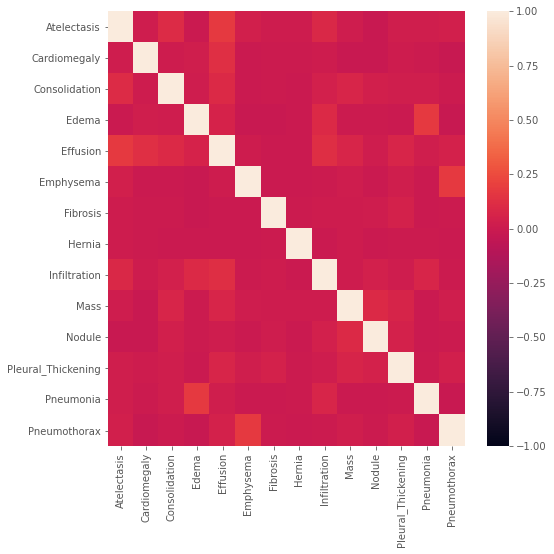

In [31]:
# distribution of other diseases that are comorbid with pneumonia
plt.figure(figsize=(8, 8))
comorbid = all_labels.copy()
comorbid.remove('No Finding')
label_df = all_xray_df[comorbid]

# Correlation
corr_df = label_df.corr()
print(corr_df['Pneumonia'].sort_values(ascending=False))
sns.heatmap(corr_df, vmin=-1, vmax=1);

As we can see 'edema' is the most positive correlated with pneumonia.

## 3.3 - Comorbid with pneumonia

On the other hand, most of the pneumonia patients also has other diseases, as we can see in the next cell.

In [32]:
# Number of pneumonia cases with no other disease
only_pn = df[all_labels_pn].sum(axis=1).value_counts()[0]
only_pn

# Percentage of pneumonia cases with no other disease
print('The percentage of pneumonia cases without any other disease are {:.1f}%'.format(
    100 * only_pn / n_cases_pn))

The percentage of pneumonia cases without any other disease are 22.5%


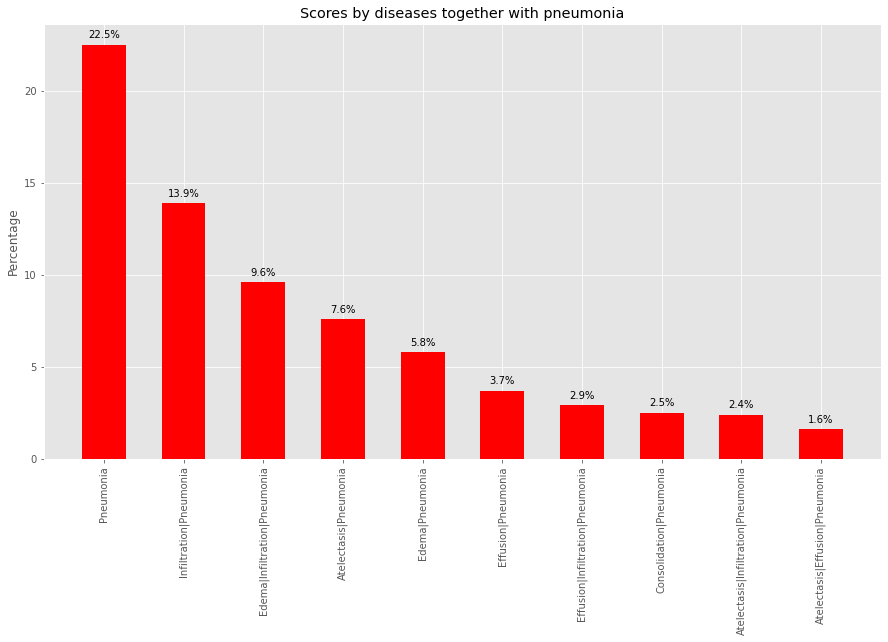

In [33]:
# Percentage of cases of pneumonia without and with other diseases
# Showing only 10 most popular cases

n = 10
fig, ax = plt.subplots(figsize=(15, 8))
values = round(100 * df['Finding Labels'].value_counts()[0:n] / n_cases_pn, 1)
bars = ax.bar(np.arange(len(values)), values, 0.55, color='r')
ind = np.arange(len(values))

# Add text for labels, title and axes ticks
ax.set_ylabel('Percentage')
ax.set_title('Scores by diseases together with pneumonia')
ax.set_xticks(ind)
plt.xticks(rotation=90)
ax.set_xticklabels(df['Finding Labels'].value_counts()[0:n].index)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., 0.25 + height,
            '{:.1f}%'.format(height), ha='center', va='bottom')

## 3.4 - Number of diseases per patient

In the entire dataset the most common situation is just one finding (one disease)

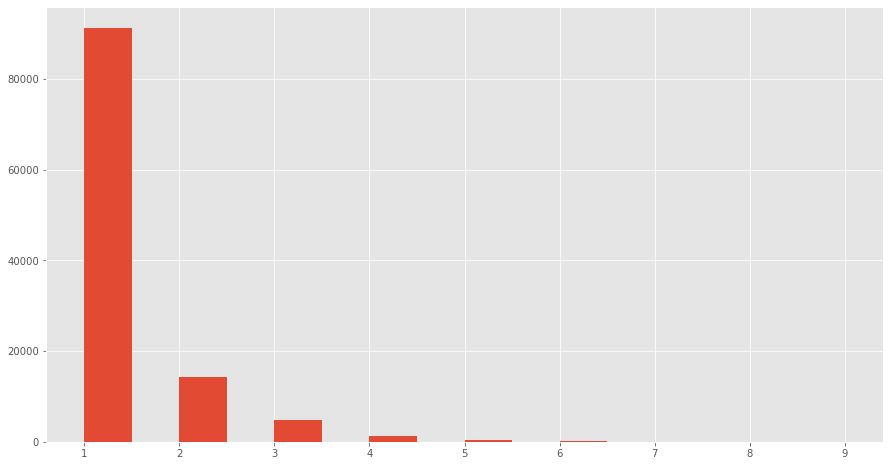

In [34]:
# Number of diseases in the full dataset
plt.figure(figsize=(15, 8))
all_xray_df[all_labels].sum(axis=1).hist(width=0.5, bins=40)

But in the pneumonia subset, the most common situation is having any other disease.

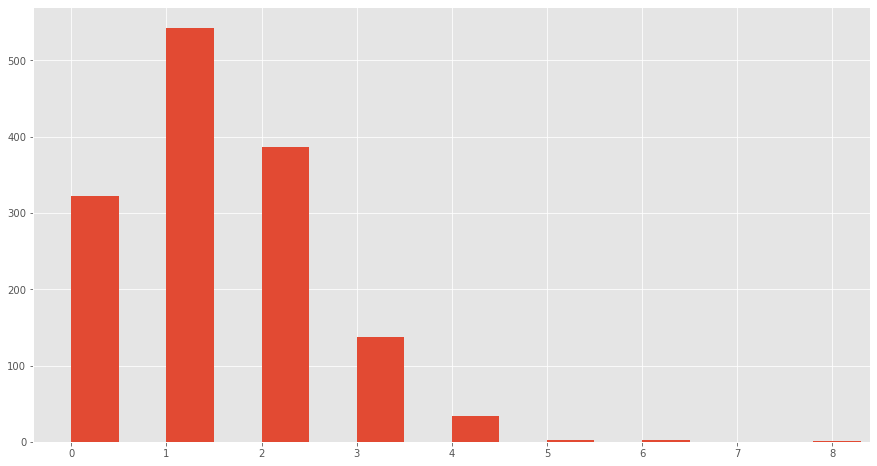

In [35]:
# Number of diseases in the pneumonia dataset
plt.figure(figsize=(15, 8))
df[all_labels_pn].sum(axis=1).hist(width=0.5, bins=40)

# 4 - Pixel level assesment

In [36]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4239,00020857_002.png,Atelectasis,2,20857,037Y,M,AP,3056,2544,0.139,0.139
3137,00015448_002.png,Atelectasis,2,15448,061Y,F,AP,2500,2048,0.168,0.168
3515,00017324_006.png,Effusion|Nodule|Pneumothorax,6,17324,035Y,F,PA,2992,2991,0.143,0.143
5045,00026810_016.png,No Finding,16,26810,055Y,M,PA,2992,2991,0.143,0.143
854,00004461_015.png,Effusion,15,4461,039Y,M,AP,3056,2544,0.139,0.139


In [37]:
# Now I create a new column in the dataframe for each disease. In each of these
# new columns I will assign a 1 if the disease is present in the "Finding Labels"
# field, and a 0 otherwise. This is the same treatment done before with the full
# dataset.
for c_label in all_labels:
    sample_df[c_label] = sample_df['Finding Labels'].map(
        lambda finding: 1.0 if c_label in finding else 0)
    # Also I count the number of ocurrences of each disease (it can be together
    # with others)
    print('{}: {:d}'.format(c_label, int(sample_df[c_label].sum())))

Atelectasis: 508
Cardiomegaly: 141
Consolidation: 226
Edema: 118
Effusion: 644
Emphysema: 127
Fibrosis: 84
Hernia: 13
Infiltration: 967
Mass: 284
No Finding: 3044
Nodule: 313
Pleural_Thickening: 176
Pneumonia: 62
Pneumothorax: 271


I want to add a new column to the dataframe with the path to the image. I start exploring the folders.

In [38]:
!ls -al /data

total 19356
drwxr-xr-x 14 root root    4096 Feb 28  2020 .
drwxr-xr-x  1 root root    4096 Jul 17 08:05 ..
-rw-r--r--  1 root root 8963138 Sep 25  2019 ARXIV_V5_CHESTXRAY.pdf
-rw-r--r--  1 root root   92416 Sep 25  2019 BBox_List_2017.csv
-rw-r--r--  1 root root 7861152 Sep 25  2019 Data_Entry_2017.csv
-rw-r--r--  1 root root   72223 Sep 25  2019 FAQ_CHESTXRAY.pdf
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_001
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_002
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_003
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_004
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_005
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_006
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_007
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_008
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_009
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_010
drwxr-xr-x  3 root root    4096 Feb 28  2020 images_011
drwxr-xr-x  3 roo

In the folder _data_ there are 12 folders. Each folder has the name "images_0XX", being XX equal to a two digit number from 01 to 12. All these folders have the same structure, that is a unique folder called "images". In it, we can find all the image files, with names "000XXXXXX_XXX.png" being X any digit.

In [39]:
# Add image paths into the dataframe

# Get paths from all images and leave them in a dict with key image filename
all_images_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/data', 'images_0??', 'images', '000?????_???.png'))}
print('Image files found: {} from {}'.format(len(all_images_paths), n_cases))

# Create a new column and map image filename to its corresponding
# path value in the created dict
sample_df['Image Path'] = sample_df['Image Index'].map(lambda x: all_images_paths[x])

Image files found: 112120 from 112104


In [40]:
sample_df[['Image Index', 'Image Path']].head()

,Image Index,Image Path
0,00000013_005.png,/data/images_001/images/00000013_005.png
1,00000013_026.png,/data/images_001/images/00000013_026.png
2,00000017_001.png,/data/images_001/images/00000017_001.png
3,00000030_001.png,/data/images_001/images/00000030_001.png
4,00000032_001.png,/data/images_001/images/00000032_001.png


Before training, a normalization of pixel values should be performed. In this case we are not going to train now, but when doing the EDA it is also recommended to do this normalization, especially if we are going to make some comparisons about the average pixel value in the histograms of a given disease.

In [41]:
# Helper function to normalize the images
def image_norm(img):
    # Return normalized image (img - mean) / std
    return (img - np.mean(img)) / np.std(img)

# Helper function to show the image and histogram
def show_img_hist(img, thresh=20):
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(14, 5))
    plt.suptitle('Image and Histogram', fontsize=16)
    
    # Normalize pixel values and create mask to avoid
    # background peak
    mask = img > thresh
    #img_n = image_norm(img)
    
    # Subplot 1 - Image
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('Image')
    plt.imshow(img, cmap='gray')
    
    # Subplot 2 - Histogram
    as2 = fig.add_subplot(1, 2, 2)
    as2.set_title('Pixel value histogram')
    plt.hist(img[mask].ravel(), bins=256)
    
    plt.show()

## 4.1 - View some samples

### 4.1.1 - Pneumonia

Image Name 00019865_013.png - Diagnostic: Pneumonia


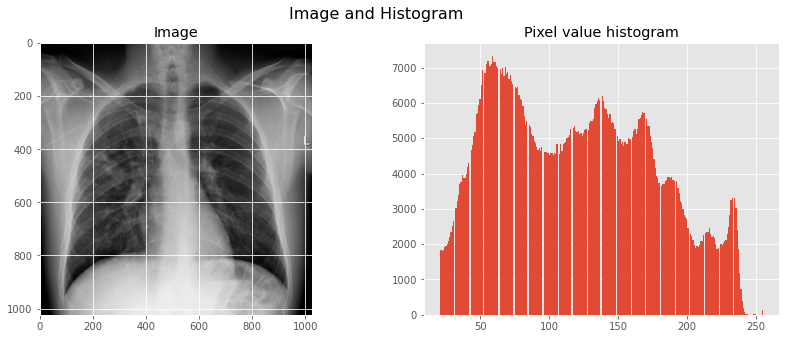

In [42]:
# Get a random sample from dataset.
# The sample is randomly selected, but with the restriction
# that it has to have pneumonia as a single diagnosis.
single_diag = 'Pneumonia'
img_s = sample_df[sample_df['Finding Labels']==single_diag].sample(random_state=0)
print('Image Name {} - Diagnostic: {}'.format(img_s['Image Index'].item(),
                                              img_s['Finding Labels'].item()))
img = io.imread(img_s['Image Path'].item())
show_img_hist(img)

### 4.1.2 - Infiltration

Image Name 00005963_023.png - Diagnostic: Infiltration


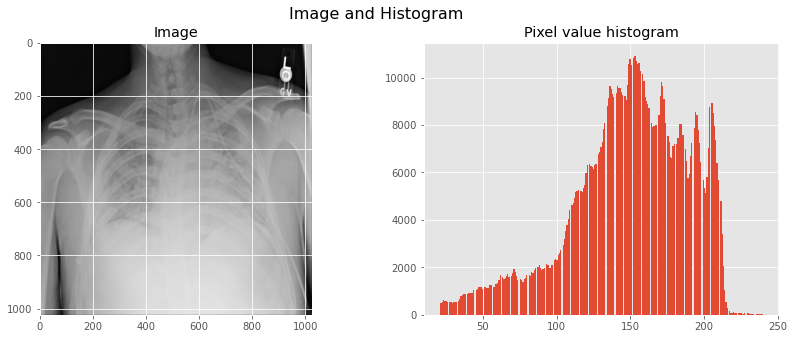

In [43]:
# Get a random sample from dataset.
# The sample is randomly selected, but with the restriction
# that it has to have infiltration as a single diagnosis.
single_diag = 'Infiltration'
img_s = sample_df[sample_df['Finding Labels']==single_diag].sample(random_state=0)
print('Image Name {} - Diagnostic: {}'.format(img_s['Image Index'].item(),
                                              img_s['Finding Labels'].item()))
img = io.imread(img_s['Image Path'].item())
show_img_hist(img)

### 4.1.3 - Edema

Image Name 00015833_002.png - Diagnostic: Edema


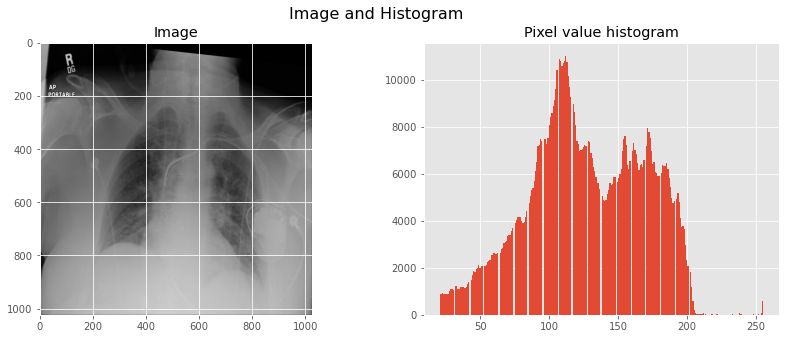

In [44]:
# Get a random sample from dataset.
# The sample is randomly selected, but with the restriction
# that it has to have edema as a single diagnosis.
single_diag = 'Edema'
img_s = sample_df[sample_df['Finding Labels']==single_diag].sample(random_state=0)
print('Image Name {} - Diagnostic: {}'.format(img_s['Image Index'].item(),
                                              img_s['Finding Labels'].item()))
img = io.imread(img_s['Image Path'].item())
show_img_hist(img)

### 4.1.4 - Atelectasis

Image Name 00015679_004.png - Diagnostic: Atelectasis


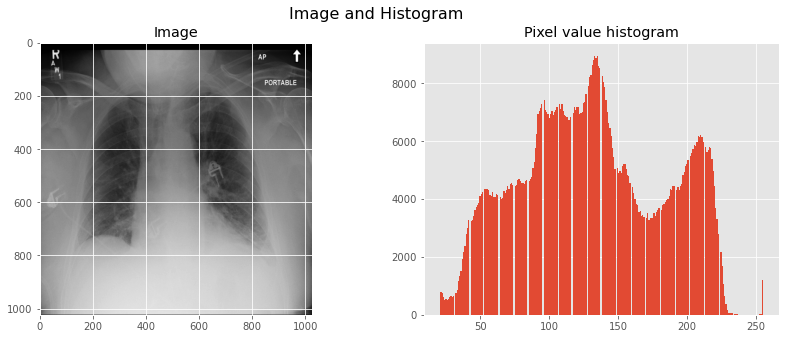

In [45]:
# Get a random sample from dataset.
# The sample is randomly selected, but with the restriction
# that it has to have atelectasis as a single diagnosis.
single_diag = 'Atelectasis'
img_s = sample_df[sample_df['Finding Labels']==single_diag].sample(random_state=0)
print('Image Name {} - Diagnostic: {}'.format(img_s['Image Index'].item(),
                                              img_s['Finding Labels'].item()))
img = io.imread(img_s['Image Path'].item())
show_img_hist(img)

## 4.2 - Means of pixel value histograms

To see if there are noticeable differences between pixel intensity value distribution, we are going to calculate a mean histogram for each single disease.

In [46]:
# We define a dictionary of mean histograms
hist_i = np.zeros_like(np.histogram(img, bins=np.arange(0, 256))[0])
hists = {name: hist_i for name in all_labels}
hists_n = {name: 0 for name in all_labels}

In [47]:
# Helper function to calculate the mean histogram
def mean_histogram(label, histog, max_samples=100, thresh=20):
    
    # Get the samples
    sdf = sample_df[sample_df['Finding Labels']==c_label]
    if len(sdf) > max_samples:
        sdf = sdf.sample(max_samples, random_state=0)
    n = len(sdf)
    
    # Calculate the sum of histograms
    for ix, s in sdf.iterrows():
        path = s['Image Path']
        img = io.imread(path)
        mask = img > thresh
        histog = histog + np.histogram(img[mask], bins=np.arange(0, 256))[0]

    # Calculate the mean
    histog = histog / n
    
    return histog, n

### 4.2.1 - Atelectasis

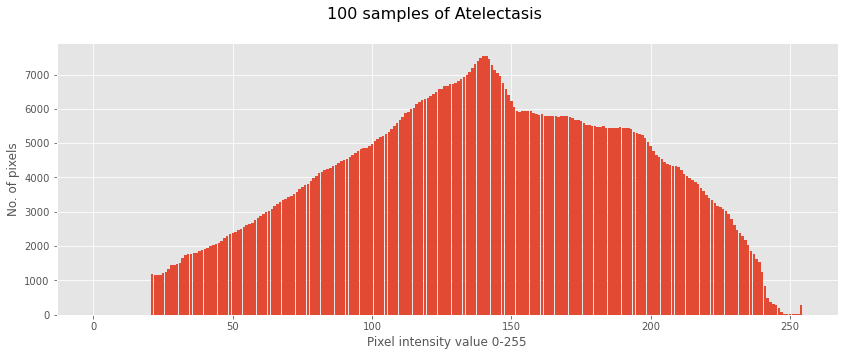

In [48]:
# Select the variable and calculate the mean histogram
c_label = 'Atelectasis'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.2 - Cardiomegaly

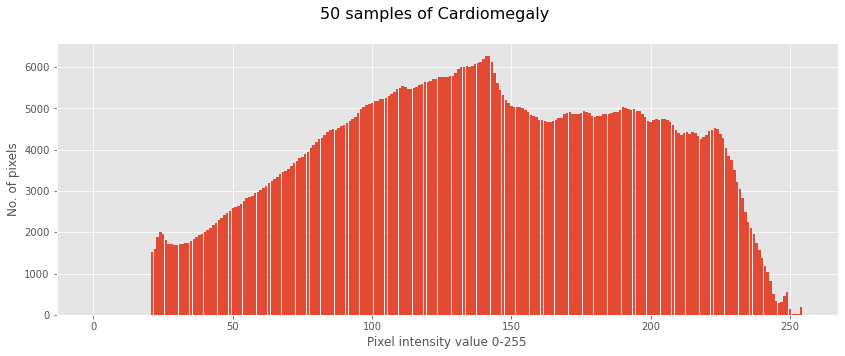

In [49]:
# Select the variable and calculate the mean histogram
c_label = 'Cardiomegaly'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.3 - Consolidation

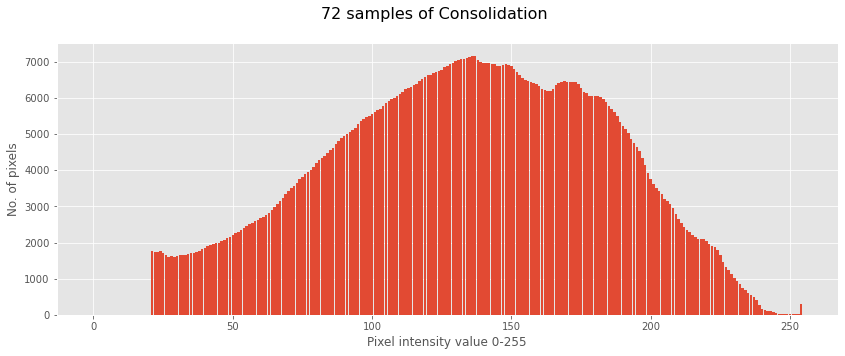

In [50]:
# Select the variable and calculate the mean histogram
c_label = 'Consolidation'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.4 - Edema

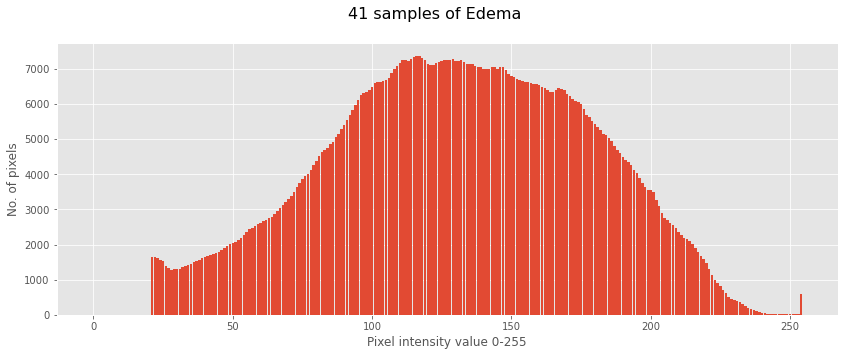

In [51]:
# Select the variable and calculate the mean histogram
c_label = 'Edema'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.5 - Effusion

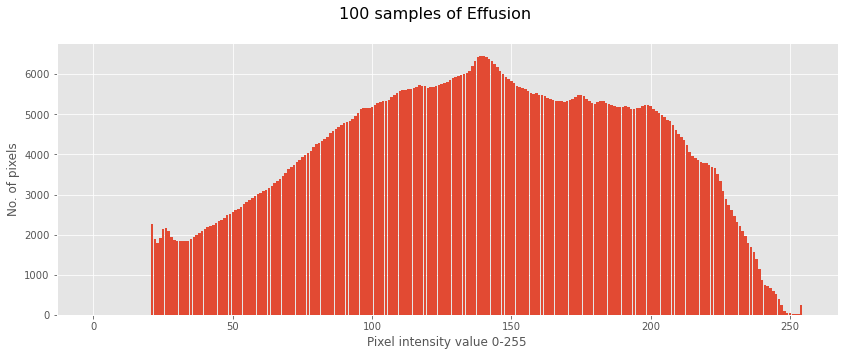

In [52]:
# Select the variable and calculate the mean histogram
c_label = 'Effusion'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.6 - Emphysema

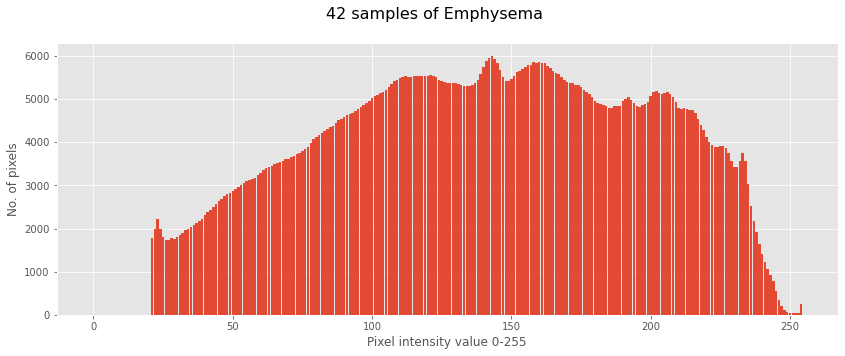

In [53]:
# Select the variable and calculate the mean histogram
c_label = 'Emphysema'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.7 - Fibrosis

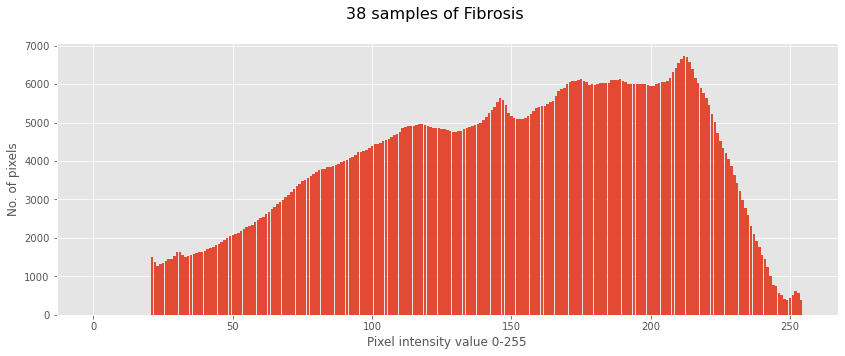

In [54]:
# Select the variable and calculate the mean histogram
c_label = 'Fibrosis'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.8 - Hernia

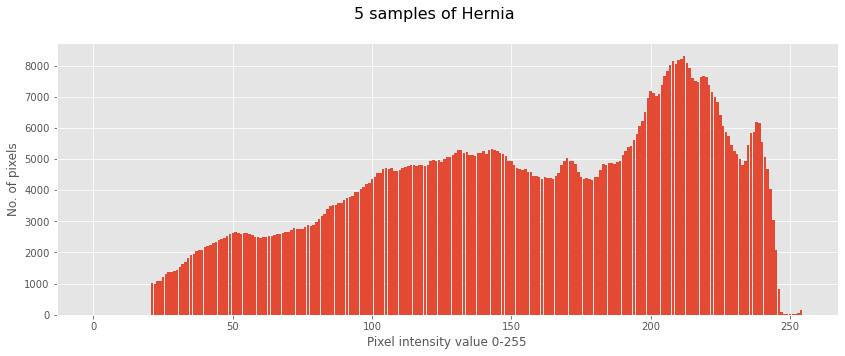

In [55]:
# Select the variable and calculate the mean histogram
c_label = 'Hernia'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.9 - Infiltration

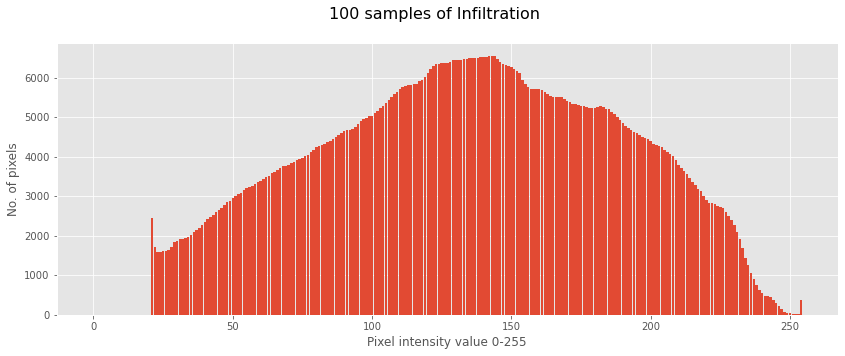

In [56]:
# Select the variable and calculate the mean histogram
c_label = 'Infiltration'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.10 - Mass

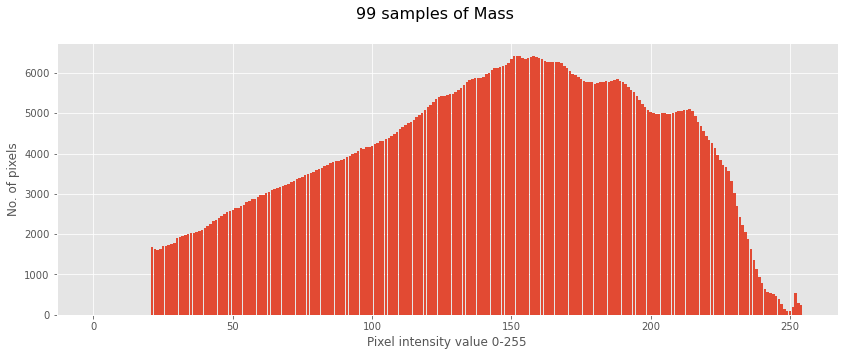

In [57]:
# Select the variable and calculate the mean histogram
c_label = 'Mass'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.11 - No Finding

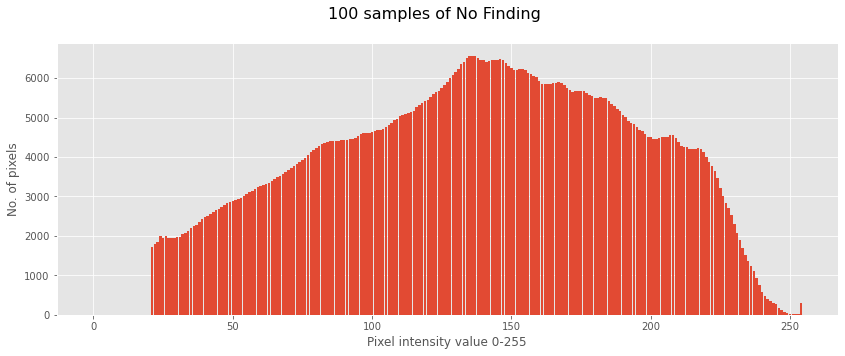

In [58]:
# Select the variable and calculate the mean histogram
c_label = 'No Finding'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.12 - Nodule

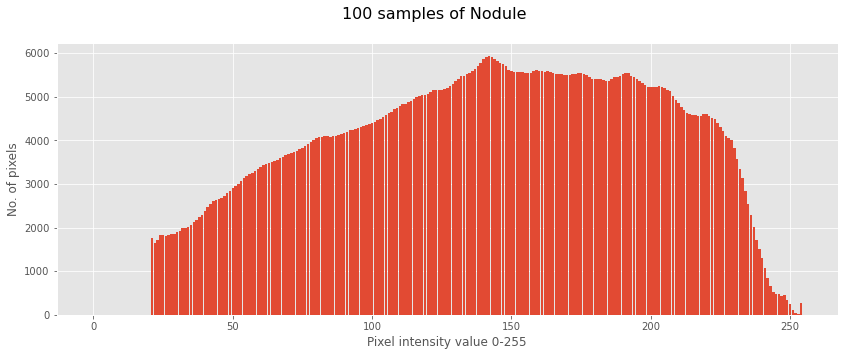

In [59]:
# Select the variable and calculate the mean histogram
c_label = 'Nodule'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.12 - Pleural_Thickening 

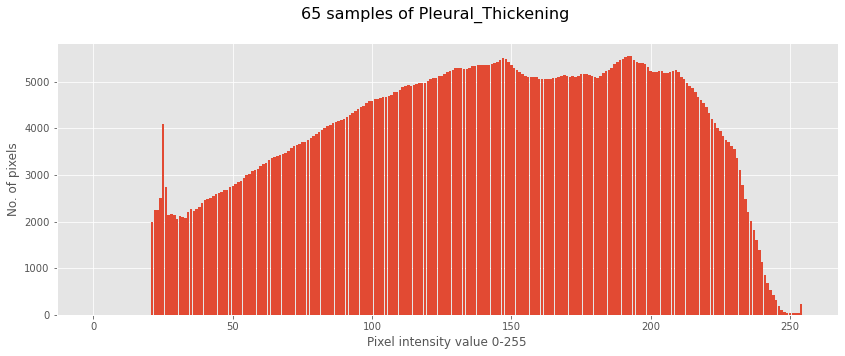

In [60]:
# Select the variable and calculate the mean histogram
c_label = 'Pleural_Thickening'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.13 - Pneumonia

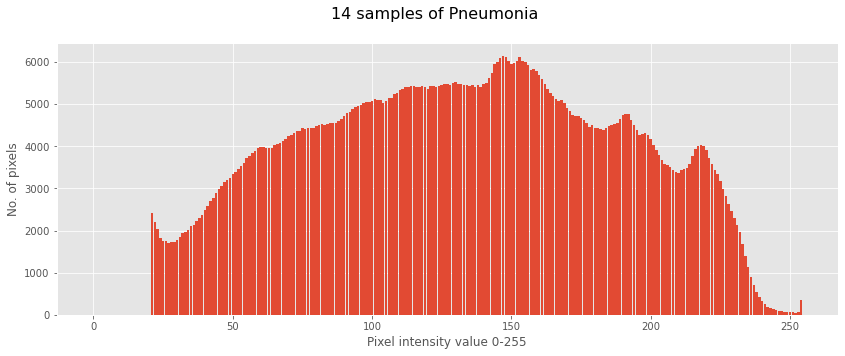

In [61]:
# Select the variable and calculate the mean histogram
c_label = 'Pneumonia'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.14 - Pneumothorax

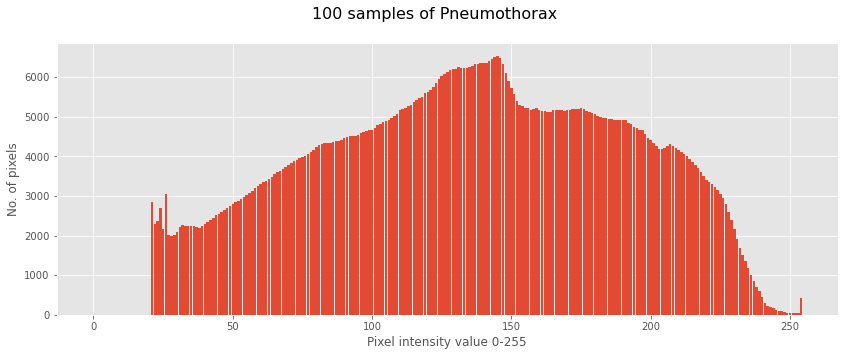

In [62]:
# Select the variable and calculate the mean histogram
c_label = 'Pneumothorax'
hists[c_label], hists_n[c_label] = mean_histogram(c_label,
                                                  hists[c_label],
                                                  max_samples=100,
                                                  thresh=20)

# Creating the bar plot
plt.style.use("ggplot")
fig = plt.figure(figsize=(14, 5))
plt.suptitle("{} samples of {}".format(hists_n[c_label], c_label), fontsize=16)
plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
 
plt.xlabel("Pixel intensity value 0-255")
plt.ylabel("No. of pixels")
plt.show()

### 4.2.15 - All histograms together

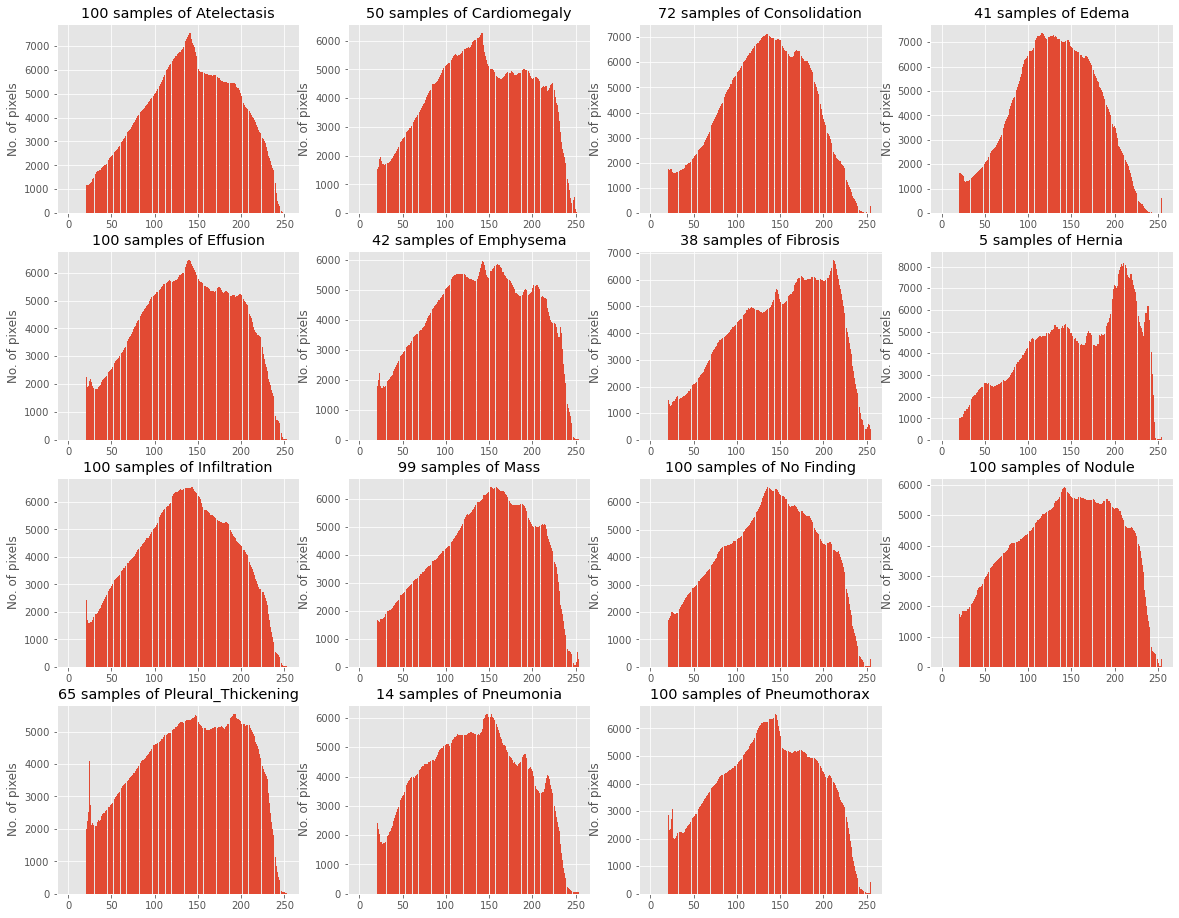

In [63]:
# And a loop through the different labels
# Only pure labels are considered, meaning that there's
# only one diagnosis.
plt.style.use("ggplot")
plt.figure(figsize=(20, 16))
for ix, c_label in enumerate(all_labels):
    plt.subplot(4, 4, 1 + ix)
    # hists[c_label], n = mean_histogram(c_label, hists[c_label], 100, 20)
    plt.bar(np.arange(0, 255), hists[c_label], width = 0.9)
    plt.ylabel("No. of pixels")
    plt.title("{} samples of {}".format(hists_n[c_label], c_label))

# 5 - Summary

We have 112,120 DICOM files in the dataset, corresponding to x-ray images from the combinations of 15 different situations (14 diseases that can be overlapped, and no disease, that can't be overlaped with any other). The cases with no disease are 60,353.

In the full dataset we have an age range from 1 to 96, with a mean of 49; while in the pneumonia subset the range is from 2 to 90 with a mean of 46.

There is a slight difference between the gender proportions in the full dataset and in the pneumonia subset (56.5% of males in the full dataset, per 58.5% of males in the pneumonia subset)

The chest radiograph is usually acquired with the X-ray beam passing through the patient from Posterior to Anterior (PA); but sometimes, due to the poor condition of the patient, it must be acquired from Anterior to Posterior (AP).

In this case the proportions of PA view in the entire dataset (60%) and pneumonia subset (44.1%) are quite different, so this data should be considered when building the training dataset. On the other hand, the population with at least one disease, has a proportion of PA of 54.1%.

More than half of the files correspond to situations labeled as "No Finding". In addition, pneumonia is usually comorbid with other diseases. Only 22.5% of pneumonia cases appear without any other disease. The most common positive correlated disease with pneumonia is edema.

All pixel intensity histograms are compared with their 0-255 gray representation. The first values (black) are removed to avoid having a peak because of the background.

The result is that, despite the fact that some variables have very different histograms, others are very difficult to distinguish only from the intensity peaks, so it is considered that the histogram method is not sufficient to be able to distinguish between different diseases.

The README file already states that the diagnosis of pneumonia from a chest X-rays can be very vague depending on the stage of the infection, hence the appearance of a good classifier from medical images can be very important.